In [1]:
# https://www.tensorflow.org/tutorials/text/transformer
# https://arxiv.org/abs/2001.08317
# https://arxiv.org/pdf/1907.00235

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
# get historical daily price
symbol = 'SPY'
ticker = yf.Ticker(symbol)
history = ticker.history(period="max")
print(ticker.ticker,history.shape)

SPY (7027, 7)


In [4]:
df = pd.DataFrame()
df['price'] = history.Close
df['log_ret'] = np.log(df.price) - np.log(df.price.shift(1))
df['ret_mean'] = df.log_ret.rolling(21).mean()
df['hist_vol'] = df.log_ret.rolling(21).std()*np.sqrt(252)*100
df = df.dropna()
df['z_vol']=np.clip(scipy.stats.zscore(df.hist_vol)/10,-1,1)
df['z_ret']=np.clip(scipy.stats.zscore(df.ret_mean)/10,-1,1)

In [5]:
np.mean(df.hist_vol),np.std(df.hist_vol)

(15.975308185776974, 10.388138878566183)

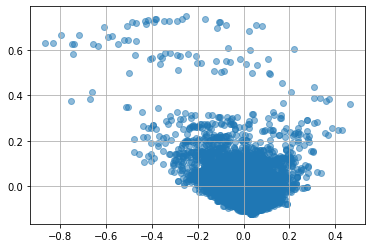

In [6]:
plt.scatter(df.z_ret,df.z_vol,alpha=0.5)
plt.grid(True)

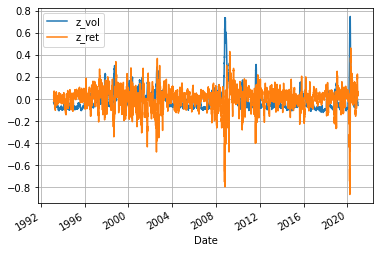

In [7]:
df[['z_vol','z_ret']].plot()
plt.grid(True)

In [8]:
# objectiv
# given x year span of z_vol, z_ret, predict next y day z_vol and z_ret

In [9]:

def etl(history):
    df = pd.DataFrame()
    df['price'] = history.Close
    df.index = history.index
    df['log_ret'] = np.log(df.price) - np.log(df.price.shift(1))
    df['ret_mean'] = df.log_ret.rolling(21).mean()
    df['hist_vol'] = df.log_ret.rolling(21).std()*np.sqrt(252)*100
    df = df.dropna()
    df['z_vol']=np.clip(scipy.stats.zscore(df.hist_vol)/10,-1,1)
    df['z_ret']=np.clip(scipy.stats.zscore(df.ret_mean)/10,-1,1)
    df['month']=df.index.month.values/12
    df['day']=df.index.day.values/31
    # add in interest rate.
    return np.stack([df.z_vol.values,df.z_ret.values,df.month.values,df.day.values],axis=-1)

#look_back=252
#look_forward=40
look_back=125
look_forward=10
total_days = look_back+look_forward-1
def chunckify(arr):
    tmp_list = []
    for x in np.arange(total_days,arr.shape[0]-total_days,5):
        tmp = arr[x:x+total_days]
        if tmp.shape != (total_days,4):
            continue
        x,y = tmp[:-1*look_forward,:],tmp[-1*look_forward:,:]
        tmp_list.append((x,y))
    return tmp_list


final_list = []
symbols = ['IWM','SPY','QQQ','GLD','SLV']
ticker_list = yf.Tickers(' '.join(symbols))
for ticker in ticker_list.tickers:
    history = ticker.history(period="max")
    print(ticker.ticker,history.shape)
    arr = etl(history)
    if arr.shape[0] > total_days:
        tmp_list = chunckify(arr)
        final_list.extend(tmp_list)

IWM (5177, 7)
SPY (7027, 7)
QQQ (5485, 7)
GLD (4052, 7)
SLV (3690, 7)


In [10]:
len(final_list),final_list[0][0].shape,final_list[0][1].shape

(4800, (124, 4), (10, 4))

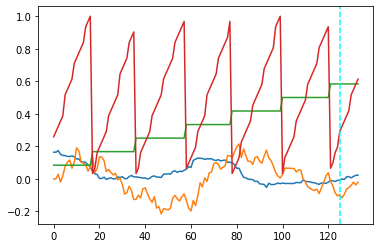

In [11]:
a=final_list[0][0]
b=final_list[0][1]
plt.plot(np.concatenate([a,b]))
plt.axvline(look_back,linestyle='--',color='cyan')

In [12]:
#https://www.tensorflow.org/tutorials/text/transformer
#http://jalammar.github.io/illustrated-transformer

In [13]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [15]:
# Add a start and end token to the input and target.
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]

    return lang1, lang2

def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])

    return result_pt, result_en



In [21]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [22]:

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [29]:

def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
    print(enc_padding_mask.shape,'enc_padding_mask!!!')
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)
    print(dec_padding_mask.shape,'dec_padding_mask!!!')
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    print(look_ahead_mask.shape,'look_ahead_mask!!!')
    dec_target_padding_mask = create_padding_mask(tar)
    print(dec_target_padding_mask.shape,'dec_target_padding_mask!!!')
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

batch_size, input_seq_len, d_model = 64,80,1
target_seq_len = 20
sample_input = tf.random.uniform((batch_size, input_seq_len, d_model), dtype=tf.float32, minval=8, maxval=8)
sample_target = tf.random.uniform((batch_size, target_seq_len, d_model), dtype=tf.float32, minval=-8, maxval=8)
enc_padding_mask, combined_mask, dec_padding_mask = create_masks(sample_input,sample_target)
print(enc_padding_mask.shape, combined_mask.shape, dec_padding_mask.shape)

(64, 1, 1, 80, 1) enc_padding_mask!!!
(64, 1, 1, 80, 1) dec_padding_mask!!!
(20, 20) look_ahead_mask!!!
(64, 1, 1, 20, 1) dec_target_padding_mask!!!
(64, 1, 1, 80, 1) (64, 1, 1, 20, 20) (64, 1, 1, 80, 1)


In [16]:


def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert self.d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights



def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])




(1, 50, 512)


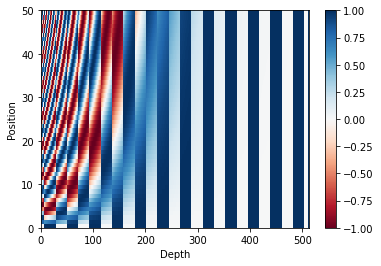

In [17]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [31]:

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, u, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2


class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2
    

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        
        #self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(d_model, 
                                                self.d_model)

        
        #self.conv = tf.keras.layers.Conv1D(1, 5, activation='relu',padding='same')
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        #x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)


class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(d_model, d_model)
        self.pos_encoding = positional_encoding(d_model, d_model)
        
        #self.conv = tf.keras.layers.Conv1D(1, 5, activation='relu',padding='same')
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        
        #x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        #x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

    

    
num_layers = 4
d_model = 124 # 128
d_model_out = 10
dff = 4
num_heads = 4
dropout_rate = 0.1

temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

# d_model, num_heads, dff
sample_encoder_layer = EncoderLayer(4, 4, 2048)
sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 124, 4)), False, None)
print(sample_encoder_layer_output.shape)  # (batch_size, input_seq_len, d_model)

sample_decoder_layer = DecoderLayer(4, 4, 2048)
sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 10, 4)), sample_encoder_layer_output, 
    False, None, None)
print(sample_decoder_layer_output.shape)  # (batch_size, target_seq_len, d_model)


NameError: name 'MultiHeadAttention' is not defined

In [32]:

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, d_model_out, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, rate)
        
        self.final_layer = tf.keras.layers.Conv1D(4, 5, activation='linear',padding='same')
        
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)

        return final_output, attention_weights


num_layers = 4
d_model = 124 # 128
d_model_out = 10
dff = 4
num_heads = 4
dropout_rate = 0.1


sample_transformer = Transformer(num_layers,d_model,num_heads,dff,d_model_out)
temp_input = tf.random.uniform((64,124, 1), dtype=tf.float32, minval=8, maxval=8)
temp_target = tf.random.uniform((64, 5, 1), dtype=tf.float32, minval=-8, maxval=8)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)


NameError: name 'positional_encoding' is not defined

In [20]:
#loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
#    from_logits=True, reduction='none')
loss_object = tf.keras.losses.Huber(delta=2.0)

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

Text(0.5, 0, 'Train Step')

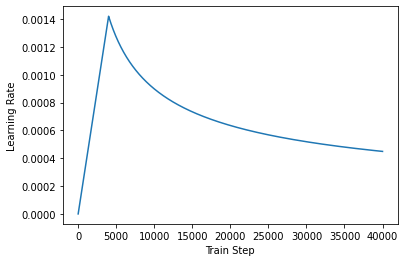

In [21]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

InvalidArgumentError: Incompatible shapes: [64,1,1,20,4] vs. [20,20] [Op:Maximum]

In [ ]:
transformer = Transformer(num_layers, d_model, num_heads, dff, d_model_out ,rate=dropout_rate)


In [23]:
! ls ./checkpoint_path

ls: cannot access './checkpoint_path': No such file or directory


In [24]:

checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
'''
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
'''
EPOCHS = 20

# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    #tf.TensorSpec(shape=(None, None), dtype=tf.float32),
    #tf.TensorSpec(shape=(None, None), dtype=tf.float32),
    tf.TensorSpec(shape=(None, d_model,dff), dtype=tf.float32),
    tf.TensorSpec(shape=(None, d_model_out,dff), dtype=tf.float32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar#[:, :-1]
    tar_real = tar#[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [25]:

X = np.stack([x[0][:,0] for x in final_list],axis=0).astype(np.float32)
y = np.stack([x[1][:,0] for x in final_list],axis=0).astype(np.float32)
X = np.expand_dims(X,axis=-1)
y = np.expand_dims(y,axis=-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


(3214, 124, 1) (3214, 10, 1) (1584, 124, 1) (1584, 10, 1)


In [26]:

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

    if batch % 50 == 0:
        print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))

    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))



ValueError: in user code:

    <ipython-input-24-5e567e8e3a1e>:37 train_step  *
        predictions, _ = transformer(inp, tar_inp,
    <ipython-input-19-d2c403d60e08>:13 call  *
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    <ipython-input-18-d16fb14de059>:90 call  *
        x += self.pos_encoding[:, :seq_len, :]
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:984 binary_op_wrapper
        return func(x, y, name=name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:1276 _add_dispatch
        return gen_math_ops.add_v2(x, y, name=name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_math_ops.py:483 add_v2
        "AddV2", x=x, y=y, name=name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/func_graph.py:595 _create_op_internal
        compute_device)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py:3327 _create_op_internal
        op_def=op_def)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py:1817 __init__
        control_input_ops, op_def)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py:1657 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 4 and 124 for '{{node transformer_1/encoder_1/add}} = AddV2[T=DT_FLOAT](transformer_1/encoder_1/mul, transformer_1/encoder_1/strided_slice_1)' with input shapes: [?,124,4], [1,?,124].


In [ ]:
def evaluate(inp_sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]

    # inp sentence is portuguese, hence adding the start and end token
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_en.vocab_size+1:
        return tf.squeeze(output, axis=0), attention_weights

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))

    sentence = tokenizer_pt.encode(sentence)

    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-1.5, -0.5)

        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                            if i < tokenizer_en.vocab_size], 
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head+1))

    plt.tight_layout()
    plt.show()

def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)

    predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")